In [37]:
import glob
import logging
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2


from patch_dataset import PatchDataset
from class_mapping import NAME2TYPELABELS_MAP
from train_utils import run_train_loop, seed_worker, plot_history
from log_utils import setup_logging

In [13]:
setup_logging()

2023-08-11 22:31:47,794-INFO-Logging setup complete.
2023-08-11 22:31:47,794-INFO-Logging setup complete.


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"pytorch device using: {device}")

2023-08-11 22:31:47,803-INFO-pytorch device using: cuda
2023-08-11 22:31:47,803-INFO-pytorch device using: cuda


In [15]:
MAGNIFICATION = "20x"
COLOR_SPACE = "RGB"

PATCH_PATH = "./data/patches"

# relative to script execution path
OUTPUT_PLOT_PATH = "./output/plots"
MODEL_SAVEPATH = "./models"

In [16]:
# load dataset
train_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/train/**/*-{MAGNIFICATION}"))

train_img_path = []
train_mask_path = []

for roi in train_patches_paths:
    train_img_path.extend(glob.glob(roi + "/patch/*.png"))
    train_mask_path.extend(glob.glob(roi + "/mask/*.png"))

train_img_path.sort()
train_mask_path.sort()

assert len(train_img_path) == len(train_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} train images: {len(train_img_path)}")

val_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/val/**/*-{MAGNIFICATION}"))

val_img_path = []
val_mask_path = []

for roi in val_patches_paths:
    val_img_path.extend(glob.glob(roi + "/patch/*.png"))
    val_mask_path.extend(glob.glob(roi + "/mask/*.png"))

val_img_path.sort()
val_mask_path.sort()

assert len(val_img_path) == len(val_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} val images: {len(val_img_path)}")

2023-08-11 22:31:48,221-INFO-Number of 20x train images: 12056
2023-08-11 22:31:48,221-INFO-Number of 20x train images: 12056
2023-08-11 22:31:48,246-INFO-Number of 20x val images: 1072
2023-08-11 22:31:48,246-INFO-Number of 20x val images: 1072


In [17]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [18]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [19]:
patch_train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode="RGB", name_to_class_mapping=NAME2TYPELABELS_MAP,
    level="patch", transform=train_transform, seed=0
)

patch_val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode="RGB", name_to_class_mapping=NAME2TYPELABELS_MAP,
    level="patch", transform=val_transform, seed=0
)

In [23]:
model = torchvision.models.resnext50_32x4d(num_classes=4)

In [24]:
torch.cuda.empty_cache()
gc.collect()

6575

100%|██████████| 377/377 [14:14<00:00,  2.27s/it]


2023-08-11 22:50:16,826-INFO-train_utils - Epoch 1/100 Train Loss: 0.9123 Validation Loss: 0.9226, Train Score: 0.6190 Validation Score: 0.7169
2023-08-11 22:50:16,826-INFO-train_utils - Epoch 1/100 Train Loss: 0.9123 Validation Loss: 0.9226, Train Score: 0.6190 Validation Score: 0.7169


100%|██████████| 377/377 [14:15<00:00,  2.27s/it]


2023-08-11 23:04:47,279-INFO-train_utils - Epoch 2/100 Train Loss: 0.8188 Validation Loss: 0.8523, Train Score: 0.7274 Validation Score: 0.7358
2023-08-11 23:04:47,279-INFO-train_utils - Epoch 2/100 Train Loss: 0.8188 Validation Loss: 0.8523, Train Score: 0.7274 Validation Score: 0.7358


100%|██████████| 377/377 [15:12<00:00,  2.42s/it]


2023-08-11 23:20:16,515-INFO-train_utils - Epoch 3/100 Train Loss: 0.7697 Validation Loss: 0.7315, Train Score: 0.8114 Validation Score: 0.7083
2023-08-11 23:20:16,515-INFO-train_utils - Epoch 3/100 Train Loss: 0.7697 Validation Loss: 0.7315, Train Score: 0.8114 Validation Score: 0.7083


100%|██████████| 377/377 [16:58<00:00,  2.70s/it]


2023-08-11 23:37:32,408-INFO-train_utils - Epoch 4/100 Train Loss: 0.7161 Validation Loss: 0.9275, Train Score: 0.8693 Validation Score: 0.7031
2023-08-11 23:37:32,408-INFO-train_utils - Epoch 4/100 Train Loss: 0.7161 Validation Loss: 0.9275, Train Score: 0.8693 Validation Score: 0.7031


100%|██████████| 377/377 [15:17<00:00,  2.43s/it]


2023-08-11 23:53:05,793-INFO-train_utils - Epoch 5/100 Train Loss: 0.6719 Validation Loss: 0.7634, Train Score: 0.9194 Validation Score: 0.8194
2023-08-11 23:53:05,793-INFO-train_utils - Epoch 5/100 Train Loss: 0.6719 Validation Loss: 0.7634, Train Score: 0.9194 Validation Score: 0.8194


100%|██████████| 377/377 [14:41<00:00,  2.34s/it]


2023-08-12 00:08:02,667-INFO-train_utils - Epoch 6/100 Train Loss: 0.6409 Validation Loss: 0.8908, Train Score: 0.8948 Validation Score: 0.8710
2023-08-12 00:08:02,667-INFO-train_utils - Epoch 6/100 Train Loss: 0.6409 Validation Loss: 0.8908, Train Score: 0.8948 Validation Score: 0.8710


100%|██████████| 377/377 [14:42<00:00,  2.34s/it]


2023-08-12 00:23:00,733-INFO-train_utils - Epoch 7/100 Train Loss: 0.6068 Validation Loss: 0.9156, Train Score: 0.7619 Validation Score: 0.8021
2023-08-12 00:23:00,733-INFO-train_utils - Epoch 7/100 Train Loss: 0.6068 Validation Loss: 0.9156, Train Score: 0.7619 Validation Score: 0.8021


100%|██████████| 377/377 [14:37<00:00,  2.33s/it]


2023-08-12 00:37:53,803-INFO-train_utils - Epoch 8/100 Train Loss: 0.5741 Validation Loss: 0.7135, Train Score: 0.9337 Validation Score: 0.8141
2023-08-12 00:37:53,803-INFO-train_utils - Epoch 8/100 Train Loss: 0.5741 Validation Loss: 0.7135, Train Score: 0.9337 Validation Score: 0.8141


100%|██████████| 377/377 [14:34<00:00,  2.32s/it]


2023-08-12 00:52:43,731-INFO-train_utils - Epoch 9/100 Train Loss: 0.5482 Validation Loss: 0.7248, Train Score: 0.9674 Validation Score: 0.8141
2023-08-12 00:52:43,731-INFO-train_utils - Epoch 9/100 Train Loss: 0.5482 Validation Loss: 0.7248, Train Score: 0.9674 Validation Score: 0.8141


100%|██████████| 377/377 [14:39<00:00,  2.33s/it]


2023-08-12 01:07:37,997-INFO-train_utils - Epoch 10/100 Train Loss: 0.5315 Validation Loss: 0.8129, Train Score: 0.9255 Validation Score: 0.9540
2023-08-12 01:07:37,997-INFO-train_utils - Epoch 10/100 Train Loss: 0.5315 Validation Loss: 0.8129, Train Score: 0.9255 Validation Score: 0.9540


100%|██████████| 377/377 [14:38<00:00,  2.33s/it]


2023-08-12 01:22:31,762-INFO-train_utils - Early stopping at epoch 11, best model at epoch 5
2023-08-12 01:22:31,762-INFO-train_utils - Early stopping at epoch 11, best model at epoch 5
2023-08-12 01:22:31,764-INFO-main - Total time taken to train the resnet_RGB_20x model: 10004.93s
2023-08-12 01:22:31,764-INFO-main - Total time taken to train the resnet_RGB_20x model: 10004.93s


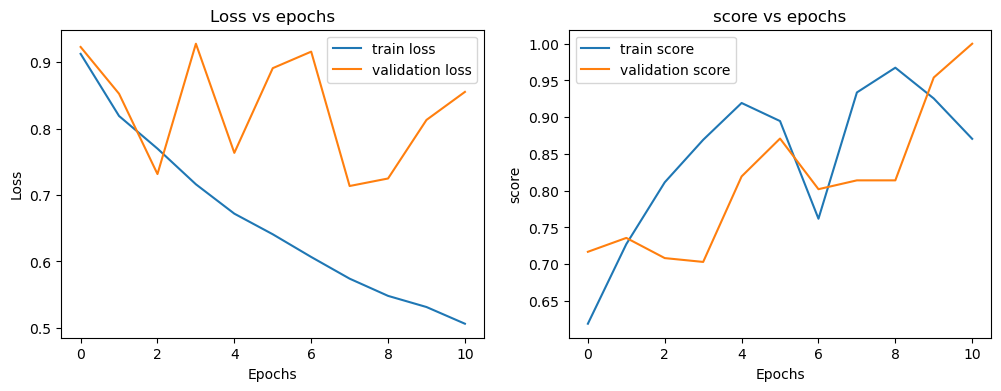

In [25]:
# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 32
EPOCHS = 100
NUM_WORKERS = 2
PREFETCH_FACTOR = 2

if __name__ == "__main__":
    

    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        patch_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    
    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    set_name = f"resnet_{COLOR_SPACE}_{MAGNIFICATION}"
    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer, set_name, save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png")